In [89]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [90]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [91]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [92]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [93]:
tf.keras.backend.clear_session()

In [94]:
subject = 'Rio Grande Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [95]:
data = pd.read_csv('2003_mo_model_input_RS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,188.093,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,170.973,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,174.880,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,178.111,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,184.331,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


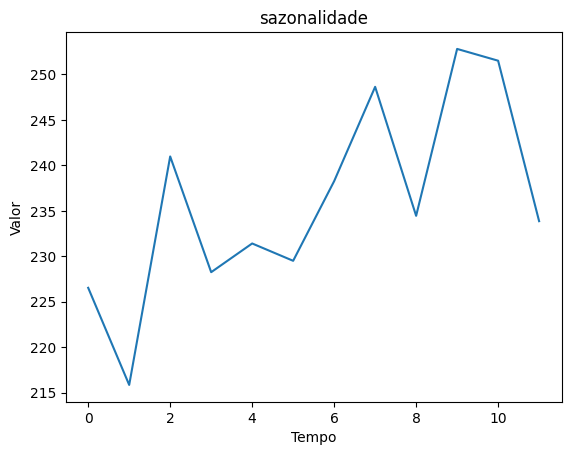

,sazonalidade
sazonalidade,
0,226.535776
1,215.861829
2,240.974809
3,228.253307
4,231.409887
5,229.504290
6,238.259767
7,248.628280
8,234.449571


In [96]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [97]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641,226.535776,188.093
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686,215.861829,170.973
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731,240.974809,174.880
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775,228.253307,178.111
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820,231.409887,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.409887,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.504290,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.259767,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.628280,NaN


In [98]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      168.412
1      153.593
2      166.196
3      150.226
4      154.220
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 273, dtype: float64

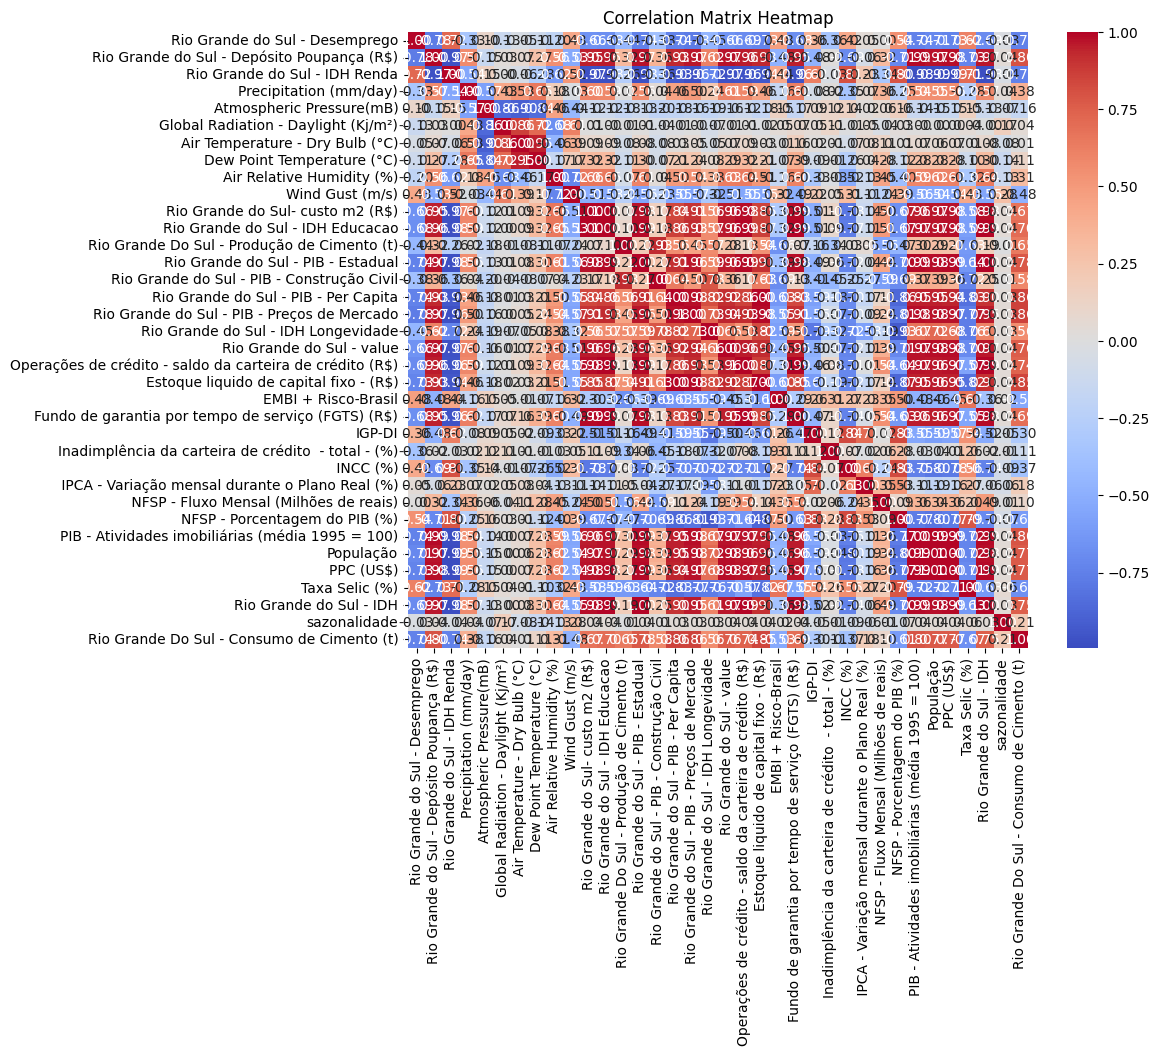

In [99]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [101]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Sul - Desemprego,1.025307e+03
1,Rio Grande do Sul - Depósito Poupança (R$),2.793969e+03
2,Rio Grande do Sul - IDH Renda,1.220445e+09
3,Precipitation (mm/day),6.439884e+00
4,Atmospheric Pressure(mB),1.826361e+07
5,Global Radiation - Daylight (Kj/m²),6.397417e+01
6,Air Temperature - Dry Bulb (°C),7.548238e+03
7,Dew Point Temperature (°C),6.068657e+03
8,Air Relative Humidity (%),9.908832e+02
9,Wind Gust (m/s),1.505766e+01


In [102]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,8.192273,2.046281e+07,0.813273,2.335964,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,135.543840,0.399576,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,226.535776
1,8.186359,2.051916e+07,0.812953,2.025977,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,134.468148,0.398811,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,215.861829
2,8.180446,2.057551e+07,0.812634,1.829198,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,134.242963,0.397898,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,240.974809
3,8.174533,2.063185e+07,0.812315,1.686795,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,133.169391,0.397042,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,228.253307
4,8.168619,2.068820e+07,0.811996,1.685569,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,132.046874,0.396050,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,231.409887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,7.357941,3.910270e+07,0.776760,2.029740,1149.533538,19.237930,15.141426,79.267533,1.505746,25414.754976,120.961794,0.620748,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,248.628280
176,7.351327,3.937243e+07,0.776794,2.293930,1243.359261,20.221419,15.922841,78.499336,1.604401,25524.770339,120.032501,0.623172,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,234.449571
177,7.344712,3.964216e+07,0.776828,2.466426,1336.757217,21.064893,16.555056,77.604382,1.713969,25636.348742,119.460653,0.625644,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,252.795021
178,7.338098,3.991189e+07,0.776862,2.615722,1420.831932,21.929072,17.304581,77.157672,1.779702,25747.718668,119.176426,0.627548,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,251.499741


In [103]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.526408,2.006117,1.578472,1.025796,1.462645,1.247081,-1.112042,0.793126,-1.532078,-0.700003,-1.332013,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-0.896883
1,-1.517303,1.976398,0.546697,0.539547,1.097205,0.931520,-0.900001,0.612463,-1.507925,-0.753907,-1.341690,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.908108
2,-1.508198,1.946679,-0.108271,-0.205800,0.511959,0.481587,-0.353326,0.510338,-1.485215,-0.765191,-1.353257,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,0.471037
3,-1.499093,1.916959,-0.582251,-0.988867,-0.221573,-0.238634,-0.062052,0.274255,-1.462829,-0.818989,-1.364083,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-0.734168
4,-1.489988,1.887240,-0.586332,-1.285972,-0.891731,-0.936501,0.067476,0.165693,-1.441756,-0.875240,-1.376647,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-0.435121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.485642,-1.392856,0.559222,-0.225317,-0.284675,0.099875,1.315618,-0.151416,1.838021,-1.430729,1.467328,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938,1.196109
176,1.529228,-1.389668,1.438564,0.326927,0.183909,0.528021,1.044413,0.443196,1.864315,-1.477297,1.498008,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688,-0.147148
177,1.572814,-1.386481,2.012709,0.876655,0.585782,0.874419,0.728458,1.103587,1.890983,-1.505953,1.529286,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616,1.590857
178,1.616400,-1.383293,2.509633,1.371507,0.997521,1.285092,0.570751,1.499776,1.917601,-1.520196,1.553383,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772,1.468145


In [104]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.526408,2.006117,1.578472,1.025796,1.462645,1.247081,-1.112042,0.793126,-1.532078,-0.700003,-1.332013,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-0.896883
1,-1.517303,1.976398,0.546697,0.539547,1.097205,0.931520,-0.900001,0.612463,-1.507925,-0.753907,-1.341690,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.908108
2,-1.508198,1.946679,-0.108271,-0.205800,0.511959,0.481587,-0.353326,0.510338,-1.485215,-0.765191,-1.353257,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,0.471037
3,-1.499093,1.916959,-0.582251,-0.988867,-0.221573,-0.238634,-0.062052,0.274255,-1.462829,-0.818989,-1.364083,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-0.734168
4,-1.489988,1.887240,-0.586332,-1.285972,-0.891731,-0.936501,0.067476,0.165693,-1.441756,-0.875240,-1.376647,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-0.435121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.991211,-1.416849,-0.309202,-0.260904,-1.117686,-0.825525,1.276690,-0.313202,1.544720,-1.078701,1.140559,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090,1.196109
164,1.029076,-1.416513,0.207601,0.447912,-0.513995,-0.330077,0.759119,0.171402,1.569103,-1.126937,1.160875,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875,-0.147148
165,1.066942,-1.416177,1.426359,0.971078,0.278721,0.485526,0.541548,0.252358,1.594036,-1.157695,1.191801,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030,1.590857
166,1.104808,-1.415841,0.994244,1.461051,1.001776,1.215141,0.296538,-0.149173,1.616833,-1.181601,1.217959,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803,1.468145


In [105]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      168.412
1      153.593
2      166.196
3      150.226
4      154.220
        ...   
163    244.406
164    201.372
165    251.369
166    242.782
167    201.288
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 168, dtype: float64

In [106]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [107]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 24)

In [108]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
132,1.224340,-0.730194,0.259745,1.281146,1.665523,1.574287,-0.778261,-0.175645,0.708652,0.537273,0.920926,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376,-0.896883
133,1.197901,-0.723162,0.277309,0.740055,1.177030,1.258244,-0.179770,-0.607064,0.736648,0.483618,0.944084,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859,-1.908108
134,1.171463,-0.716130,0.049038,-0.176175,0.414805,0.701406,0.651943,-1.140018,0.764965,0.434802,0.962166,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952,0.471037
135,1.145025,-0.709097,0.108416,-0.808523,-0.274140,0.096340,1.141319,-1.536494,0.793211,0.385040,0.980232,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200,-0.734168
136,1.118586,-0.702065,0.317012,-1.200278,-0.902759,-0.508650,1.460809,-1.912376,0.821549,0.334744,1.000912,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944,-0.435121
137,1.092148,-0.695033,0.633765,-1.304075,-1.084573,-0.669434,1.590120,-1.737427,0.850429,0.283743,1.019037,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692,-0.615653
138,1.065710,-0.688001,1.007363,-0.904373,-0.910668,-0.587373,1.247604,-1.581700,0.879178,0.232581,1.024007,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126,0.213821
139,1.039271,-0.680968,0.728689,-0.273637,-0.494181,-0.287104,0.801491,-1.429206,0.904734,0.181174,1.031093,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065,1.196109
140,1.012833,-0.673936,0.692109,0.194534,0.134441,0.340073,0.574302,-1.102566,0.930454,0.129412,1.037745,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206,-0.147148
141,0.986394,-0.666904,1.107471,0.697475,0.783124,0.934974,0.197336,-1.034204,0.958869,0.077551,1.049164,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794,1.590857


In [109]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [110]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells,
               third_layer_n_cells,
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(
        second_layer_n_cells,
        activation='tanh',
        return_sequences=(third_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
        
    if third_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.LSTM(
            third_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.14,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [111]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells, third_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells, third_layer_n_cells,
                                    want_verbose=0, seed=seed)
        
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(sorted(list_loss)[:4])

In [112]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [36, 72, 144]
third_layer_cells_list = [0, 36, 72, 144]

In [113]:
def hyperparameter_tuning(train_input, train_target, 
                          first_layer_cells_list, second_layer_cells_list, third_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            for third_cells in third_layer_cells_list:
                if not third_cells > second_cells:
                    print(f"_________________________________________________________________________________________")
                    print(" ")
                    print(f" Testing [{first_cells}, {second_cells}, {third_cells}]")
                    print(f"_________________________________________________________________________________________")

                    winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                                first_cells, second_cells, third_cells)
                    print(" ")
                    print(f"first_layer_n_cells: {first_cells}")
                    print(f"second_layer_n_cells: {second_cells}")
                    print(f"third_layer_n_cells: {third_cells}")
                    if mean_loss < best_loss:
                        best_loss = mean_loss
                        best_combination = [first_cells, second_cells, third_cells, winner_seed]
                        print(f"best_loss: {best_loss}")
                        print(f"winner_seed: {winner_seed}")
                    print(" ")
            
    return best_combination

In [114]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list, 
                                         third_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
 Testing [36, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 984.0222778320312
winner_seed: 4085039493


Step: 1 ___________________________________________
val_loss: 412.5740661621094
winner_seed: 2727200493


Step: 2 ___________________________________________
val_loss: 687.9177856445312


Step: 3 ___________________________________________
val_loss: 640.6755981445312


Step: 4 ___________________________________________
val_loss: 336.41143798828125
winner_seed: 3304044475
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 0
best_loss: 519.3947219848633
winner_seed: 3304044475
 
_________________________________________________________________________________________
 
 Testing [36, 36, 36]
_______________________________________________________________________

val_loss: 596.080322265625


Step: 4 ___________________________________________
val_loss: 503.9707946777344
 
first_layer_n_cells: 72
second_layer_n_cells: 36
third_layer_n_cells: 36
 
_________________________________________________________________________________________
 
 Testing [72, 72, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 545.43505859375
winner_seed: 3720882247


Step: 1 ___________________________________________
val_loss: 477.853271484375
winner_seed: 67248247


Step: 2 ___________________________________________
val_loss: 4077884416.0


Step: 3 ___________________________________________
val_loss: 820.2721557617188


Step: 4 ___________________________________________
val_loss: 512.6929321289062
 
first_layer_n_cells: 72
second_layer_n_cells: 72
third_layer_n_cells: 0
 
_______________________________________________________________________________________

val_loss: 446.786865234375
 
first_layer_n_cells: 144
second_layer_n_cells: 72
third_layer_n_cells: 36
 
_________________________________________________________________________________________
 
 Testing [144, 72, 72]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 448.2685546875
winner_seed: 2127449609


Step: 1 ___________________________________________
val_loss: 540.6298217773438


Step: 2 ___________________________________________
val_loss: 442.6786193847656
winner_seed: 2098780106


Step: 3 ___________________________________________
val_loss: 358.0654296875
winner_seed: 3606985763


Step: 4 ___________________________________________
val_loss: 2738991398912.0
 
first_layer_n_cells: 144
second_layer_n_cells: 72
third_layer_n_cells: 72
 
_________________________________________________________________________________________
 
 Testing [144, 144, 0]
_______________________

[36, 144, 144, 3232920431]

In [115]:
best_combination

[36, 144, 144, 3232920431]

In [116]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], best_combination[2],
                                    want_verbose=1, 
                                    seed=best_combination[3])

Epoch 1/10000
4/4 [==============================] - 2s 161ms/step - loss: 47196.8047 - val_loss: 1988.3641
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 1216.1805 - val_loss: 2314.8679
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 1186.6030 - val_loss: 2368.5718
Epoch 4/10000
4/4 [==============================] - 0s 10ms/step - loss: 1220.8032 - val_loss: 2768.5623
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 1248.8143 - val_loss: 3107.6433
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 1257.4358 - val_loss: 2226.4990
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 1187.1447 - val_loss: 3072.1199
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 1204.4460 - val_loss: 1816.3429
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 1222.1346 - val_loss: 1888.3375
Epoch 10/10000
4/4 [============================

4/4 [==============================] - 0s 9ms/step - loss: 1144.5873 - val_loss: 2378.7168
Epoch 79/10000
4/4 [==============================] - 0s 9ms/step - loss: 1210.3851 - val_loss: 1736.5531
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 1143.1605 - val_loss: 2562.2312
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 1145.7540 - val_loss: 1542.1279
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 1131.4373 - val_loss: 2339.6204
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 1168.0310 - val_loss: 1831.7175
Epoch 84/10000
4/4 [==============================] - 0s 10ms/step - loss: 1148.0750 - val_loss: 785.2938
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 1340.0341 - val_loss: 848.8887
Epoch 86/10000
4/4 [==============================] - 0s 10ms/step - loss: 1136.0999 - val_loss: 2396.6204
Epoch 87/10000
4/4 [==============================] - 0s 9m

4/4 [==============================] - 0s 9ms/step - loss: 1205.9788 - val_loss: 1009.6219
Epoch 155/10000
4/4 [==============================] - 0s 9ms/step - loss: 1322.7059 - val_loss: 1489.6748
Epoch 156/10000
4/4 [==============================] - 0s 9ms/step - loss: 1308.4771 - val_loss: 1721.9598
Epoch 157/10000
4/4 [==============================] - 0s 9ms/step - loss: 1174.9364 - val_loss: 2813.2363
Epoch 158/10000
4/4 [==============================] - 0s 9ms/step - loss: 1180.8344 - val_loss: 2434.6660
Epoch 159/10000
4/4 [==============================] - 0s 9ms/step - loss: 1144.6635 - val_loss: 920.6020
Epoch 160/10000
4/4 [==============================] - 0s 9ms/step - loss: 1215.4204 - val_loss: 807.7027
Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 1282.5157 - val_loss: 1664.1522
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 1112.2028 - val_loss: 1291.3326
Epoch 163/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 9ms/step - loss: 398.1671 - val_loss: 452.8205
Epoch 232/10000
4/4 [==============================] - 0s 9ms/step - loss: 368.0801 - val_loss: 446.0728
Epoch 233/10000
4/4 [==============================] - 0s 9ms/step - loss: 392.0786 - val_loss: 445.4661
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 343.6591 - val_loss: 486.6807
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 485.7596 - val_loss: 452.1991
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 341.5455 - val_loss: 508.7281
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 337.9479 - val_loss: 449.0496
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 326.6927 - val_loss: 448.9524
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 480.1811 - val_loss: 501.6801
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 274.8105 - val_loss: 473.6090
Epoch 310/10000
4/4 [==============================] - 0s 9ms/step - loss: 413.0546 - val_loss: 467.3810
Epoch 311/10000
4/4 [==============================] - 0s 9ms/step - loss: 261.5520 - val_loss: 438.4748
Epoch 312/10000
4/4 [==============================] - 0s 9ms/step - loss: 251.6176 - val_loss: 438.8980
Epoch 313/10000
4/4 [==============================] - 0s 9ms/step - loss: 254.1742 - val_loss: 464.6109
Epoch 314/10000
4/4 [==============================] - 0s 9ms/step - loss: 282.4875 - val_loss: 445.1672
Epoch 315/10000
4/4 [==============================] - 0s 9ms/step - loss: 253.4413 - val_loss: 445.2071
Epoch 316/10000
4/4 [==============================] - 0s 9ms/step - loss: 286.6410 - val_loss: 433.6228
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 339.9034 - val_loss: 536.7540
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 205.7155 - val_loss: 452.7835
Epoch 388/10000
4/4 [==============================] - 0s 9ms/step - loss: 203.9306 - val_loss: 561.9105
Epoch 389/10000
4/4 [==============================] - 0s 9ms/step - loss: 272.7499 - val_loss: 484.8275
Epoch 390/10000
4/4 [==============================] - 0s 9ms/step - loss: 238.0584 - val_loss: 471.3702
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 240.4409 - val_loss: 410.8706
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 215.7630 - val_loss: 386.1789
Epoch 393/10000
4/4 [==============================] - 0s 9ms/step - loss: 203.0280 - val_loss: 419.1337
Epoch 394/10000
4/4 [==============================] - 0s 9ms/step - loss: 207.9797 - val_loss: 419.6624
Epoch 395/10000
4/4 [==============================] - 0s 9ms/step - loss: 192.7737 - val_loss: 487.8749
Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 10ms/step - loss: 182.1642 - val_loss: 417.6110
Epoch 466/10000
4/4 [==============================] - 0s 9ms/step - loss: 162.9376 - val_loss: 419.8391
Epoch 467/10000
4/4 [==============================] - 0s 9ms/step - loss: 180.2397 - val_loss: 538.7484
Epoch 468/10000
4/4 [==============================] - 0s 9ms/step - loss: 199.2371 - val_loss: 603.6830
Epoch 469/10000
4/4 [==============================] - 0s 9ms/step - loss: 226.7135 - val_loss: 505.7277
Epoch 470/10000
4/4 [==============================] - 0s 9ms/step - loss: 185.5318 - val_loss: 465.6180
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 186.7334 - val_loss: 441.2092
Epoch 472/10000
4/4 [==============================] - 0s 9ms/step - loss: 176.9877 - val_loss: 456.4280
Epoch 473/10000
4/4 [==============================] - 0s 10ms/step - loss: 170.3182 - val_loss: 443.5074
Epoch 474/10000
4/4 [==============================] - 0s 9ms/step - 

4/4 [==============================] - 0s 9ms/step - loss: 227.2533 - val_loss: 575.5618
Epoch 544/10000
4/4 [==============================] - 0s 9ms/step - loss: 220.1174 - val_loss: 514.6771
Epoch 545/10000
4/4 [==============================] - 0s 9ms/step - loss: 201.2634 - val_loss: 476.3912
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 202.7449 - val_loss: 530.5617
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 207.7069 - val_loss: 468.3990
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 225.2080 - val_loss: 453.8120
Epoch 549/10000
4/4 [==============================] - 0s 9ms/step - loss: 212.7114 - val_loss: 445.1360
Epoch 550/10000
4/4 [==============================] - 0s 9ms/step - loss: 191.5673 - val_loss: 524.3745
Epoch 551/10000
4/4 [==============================] - 0s 9ms/step - loss: 193.1209 - val_loss: 515.8922
Epoch 552/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 167.1831 - val_loss: 447.3156
Epoch 622/10000
4/4 [==============================] - 0s 9ms/step - loss: 164.6177 - val_loss: 466.8472
Epoch 623/10000
4/4 [==============================] - 0s 9ms/step - loss: 174.1634 - val_loss: 444.3960
Epoch 624/10000
4/4 [==============================] - 0s 9ms/step - loss: 187.5703 - val_loss: 452.9182
Epoch 625/10000
4/4 [==============================] - 0s 9ms/step - loss: 184.9793 - val_loss: 434.9731
Epoch 626/10000
4/4 [==============================] - 0s 9ms/step - loss: 195.0684 - val_loss: 461.9333
Epoch 627/10000
4/4 [==============================] - 0s 9ms/step - loss: 189.0834 - val_loss: 445.0190
Epoch 628/10000
4/4 [==============================] - 0s 9ms/step - loss: 181.8517 - val_loss: 460.3881
Epoch 629/10000
4/4 [==============================] - 0s 9ms/step - loss: 187.7281 - val_loss: 470.7157
Epoch 630/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 147.5776 - val_loss: 526.5931
Epoch 700/10000
4/4 [==============================] - 0s 9ms/step - loss: 132.3968 - val_loss: 568.5884
Epoch 701/10000
4/4 [==============================] - 0s 9ms/step - loss: 140.3277 - val_loss: 515.0504
Epoch 702/10000
4/4 [==============================] - 0s 9ms/step - loss: 140.4164 - val_loss: 540.2220
Epoch 703/10000
4/4 [==============================] - 0s 9ms/step - loss: 131.2309 - val_loss: 497.2249
Epoch 704/10000
4/4 [==============================] - 0s 9ms/step - loss: 136.9727 - val_loss: 561.4124
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 133.5319 - val_loss: 507.6506
Epoch 706/10000
4/4 [==============================] - 0s 9ms/step - loss: 144.6121 - val_loss: 503.5348
Epoch 707/10000
4/4 [==============================] - 0s 9ms/step - loss: 144.4680 - val_loss: 544.0316
Epoch 708/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 121.3447 - val_loss: 536.3391
Epoch 778/10000
4/4 [==============================] - 0s 9ms/step - loss: 125.5015 - val_loss: 532.5555
Epoch 779/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.9305 - val_loss: 544.1843
Epoch 780/10000
4/4 [==============================] - 0s 9ms/step - loss: 120.9524 - val_loss: 550.0233
Epoch 781/10000
4/4 [==============================] - 0s 9ms/step - loss: 122.8702 - val_loss: 536.8978
Epoch 782/10000
4/4 [==============================] - 0s 9ms/step - loss: 127.6789 - val_loss: 535.2808
Epoch 783/10000
4/4 [==============================] - 0s 9ms/step - loss: 132.5671 - val_loss: 538.2029
Epoch 784/10000
4/4 [==============================] - 0s 9ms/step - loss: 130.3742 - val_loss: 538.1004
Epoch 785/10000
4/4 [==============================] - 0s 9ms/step - loss: 125.5817 - val_loss: 556.1190
Epoch 786/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 116.0502 - val_loss: 541.0319
Epoch 856/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.4952 - val_loss: 540.5891
Epoch 857/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.7133 - val_loss: 529.5262
Epoch 858/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.8848 - val_loss: 565.2676
Epoch 859/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.4040 - val_loss: 558.7590
Epoch 860/10000
4/4 [==============================] - 0s 9ms/step - loss: 118.4302 - val_loss: 550.2133
Epoch 861/10000
4/4 [==============================] - 0s 9ms/step - loss: 128.7566 - val_loss: 537.0836
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.8756 - val_loss: 555.0339
Epoch 863/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.6300 - val_loss: 586.6052
Epoch 864/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 121.6172 - val_loss: 519.4225
Epoch 934/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.5412 - val_loss: 500.7775
Epoch 935/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.8089 - val_loss: 508.9531
Epoch 936/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.5590 - val_loss: 486.8794
Epoch 937/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.6015 - val_loss: 523.5671
Epoch 938/10000
4/4 [==============================] - 0s 9ms/step - loss: 113.3964 - val_loss: 513.8489
Epoch 939/10000
4/4 [==============================] - 0s 9ms/step - loss: 114.2235 - val_loss: 517.8367
Epoch 940/10000
4/4 [==============================] - 0s 9ms/step - loss: 105.2975 - val_loss: 518.3920
Epoch 941/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.5650 - val_loss: 527.1077
Epoch 942/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 96.1194 - val_loss: 488.1777
Epoch 1012/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.8187 - val_loss: 479.5934
Epoch 1013/10000
4/4 [==============================] - 0s 9ms/step - loss: 119.1400 - val_loss: 484.6110
Epoch 1014/10000
4/4 [==============================] - 0s 9ms/step - loss: 95.4384 - val_loss: 510.3210
Epoch 1015/10000
4/4 [==============================] - 0s 11ms/step - loss: 101.4387 - val_loss: 478.6883
Epoch 1016/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.0190 - val_loss: 481.2862
Epoch 1017/10000
4/4 [==============================] - 0s 10ms/step - loss: 84.1704 - val_loss: 489.3067
Epoch 1018/10000
4/4 [==============================] - 0s 11ms/step - loss: 87.5094 - val_loss: 517.8893
Epoch 1019/10000
4/4 [==============================] - 0s 10ms/step - loss: 93.0479 - val_loss: 518.5707
Epoch 1020/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 10ms/step - loss: 65.5260 - val_loss: 523.8857
Epoch 1089/10000
4/4 [==============================] - 0s 10ms/step - loss: 67.0578 - val_loss: 520.8575
Epoch 1090/10000
4/4 [==============================] - 0s 10ms/step - loss: 72.3886 - val_loss: 534.4413
Epoch 1091/10000
4/4 [==============================] - 0s 11ms/step - loss: 69.9251 - val_loss: 536.1196
Epoch 1092/10000
4/4 [==============================] - 0s 10ms/step - loss: 86.9779 - val_loss: 528.1553
Epoch 1093/10000
4/4 [==============================] - 0s 9ms/step - loss: 70.1718 - val_loss: 508.1293
Epoch 1094/10000
4/4 [==============================] - 0s 9ms/step - loss: 76.5754 - val_loss: 522.3562
Epoch 1095/10000
4/4 [==============================] - 0s 9ms/step - loss: 71.3749 - val_loss: 517.1150
Epoch 1096/10000
4/4 [==============================] - 0s 9ms/step - loss: 69.6704 - val_loss: 502.9936
Epoch 1097/10000
4/4 [==============================] - 0s 9ms/step

4/4 [==============================] - 0s 9ms/step - loss: 65.9474 - val_loss: 341.0432
Epoch 1166/10000
4/4 [==============================] - 0s 9ms/step - loss: 74.8406 - val_loss: 391.4505
Epoch 1167/10000
4/4 [==============================] - 0s 9ms/step - loss: 77.4961 - val_loss: 349.1642
Epoch 1168/10000
4/4 [==============================] - 0s 9ms/step - loss: 76.5858 - val_loss: 392.0747
Epoch 1169/10000
4/4 [==============================] - 0s 9ms/step - loss: 80.5633 - val_loss: 377.0710
Epoch 1170/10000
4/4 [==============================] - 0s 10ms/step - loss: 94.2218 - val_loss: 335.3234
Epoch 1171/10000
4/4 [==============================] - 0s 10ms/step - loss: 62.3296 - val_loss: 327.5061
Epoch 1172/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.2509 - val_loss: 351.7066
Epoch 1173/10000
4/4 [==============================] - 0s 9ms/step - loss: 65.9413 - val_loss: 370.5885
Epoch 1174/10000
4/4 [==============================] - 0s 9ms/step - 

4/4 [==============================] - 0s 9ms/step - loss: 52.0037 - val_loss: 371.9061
Epoch 1244/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.1699 - val_loss: 371.6242
Epoch 1245/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.0595 - val_loss: 387.2870
Epoch 1246/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.8486 - val_loss: 356.3646
Epoch 1247/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.3588 - val_loss: 360.8907
Epoch 1248/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.8006 - val_loss: 355.4702
Epoch 1249/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.0129 - val_loss: 358.8294
Epoch 1250/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.8678 - val_loss: 338.5513
Epoch 1251/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.8006 - val_loss: 360.8236
Epoch 1252/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 43.4901 - val_loss: 333.4373
Epoch 1322/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.0563 - val_loss: 359.5487
Epoch 1323/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.8485 - val_loss: 344.4679
Epoch 1324/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.5461 - val_loss: 334.1734
Epoch 1325/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.8822 - val_loss: 335.9570
Epoch 1326/10000
4/4 [==============================] - 0s 9ms/step - loss: 41.6854 - val_loss: 339.6542
Epoch 1327/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.0269 - val_loss: 350.7918
Epoch 1328/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.8710 - val_loss: 373.6207
Epoch 1329/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.0547 - val_loss: 354.4024
Epoch 1330/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 37.9992 - val_loss: 360.6223
Epoch 1400/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.8413 - val_loss: 364.6922
Epoch 1401/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.8701 - val_loss: 353.1994
Epoch 1402/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.1260 - val_loss: 367.5768
Epoch 1403/10000
4/4 [==============================] - 0s 9ms/step - loss: 39.6671 - val_loss: 367.7240
Epoch 1404/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.0882 - val_loss: 364.0470
Epoch 1405/10000
4/4 [==============================] - 0s 9ms/step - loss: 39.7644 - val_loss: 380.3907
Epoch 1406/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.1881 - val_loss: 378.3285
Epoch 1407/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.3083 - val_loss: 375.4655
Epoch 1408/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 33.9871 - val_loss: 353.3730
Epoch 1478/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.9097 - val_loss: 345.7728
Epoch 1479/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.6408 - val_loss: 344.6115
Epoch 1480/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.5713 - val_loss: 350.1559
Epoch 1481/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.8716 - val_loss: 354.4669
Epoch 1482/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.8780 - val_loss: 351.9324
Epoch 1483/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.5401 - val_loss: 348.1562
Epoch 1484/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.1047 - val_loss: 348.2428
Epoch 1485/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.6719 - val_loss: 360.6709
Epoch 1486/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 32.7978 - val_loss: 345.3347
Epoch 1556/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.3002 - val_loss: 351.6729
Epoch 1557/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.9075 - val_loss: 348.8073
Epoch 1558/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.7632 - val_loss: 348.1709
Epoch 1559/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.6235 - val_loss: 355.4045
Epoch 1560/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.5965 - val_loss: 348.4962
Epoch 1561/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.9177 - val_loss: 344.9930
Epoch 1562/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.7417 - val_loss: 347.8991
Epoch 1563/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.4212 - val_loss: 340.4822
Epoch 1564/10000
4/4 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 28.9098 - val_loss: 390.0029
Epoch 1634/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.5021 - val_loss: 464.8401
Epoch 1635/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.1308 - val_loss: 468.7903
Epoch 1636/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.1851 - val_loss: 493.9467
Epoch 1637/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.5273 - val_loss: 493.2858
Epoch 1638/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.2903 - val_loss: 493.2686
Epoch 1639/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.1866 - val_loss: 487.1791
Epoch 1640/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.9287 - val_loss: 479.4073
Epoch 1641/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.2899 - val_loss: 434.9393
Epoch 1642/10000
4/4 [==============================] - 0s 9ms/step - lo

In [117]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [118]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,210.423752,219.345276,221.444489,210.701294,218.434082,218.859146,223.975952,248.479874,237.990967,249.299637,232.283813,216.971481
Target,226.547,228.5,223.896,234.132,207.586,228.583,234.565,249.519,230.086,233.136,233.8,223.214
Error,16.123245,9.154724,2.451508,23.43071,10.848083,9.723846,10.58905,1.039124,7.904968,16.163635,1.51619,6.242523


In [119]:
display(mae)
display(mape)

9.598968

0.042041946